# Import Libraries

In [37]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback
import math

In [163]:
import networkx as nx
import itertools

from qiskit.algorithms import AmplificationProblem
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator
from qiskit.extensions import Initialize

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

from itertools import product 
from qiskit.quantum_info import Statevector

# Keywords

Classical approach: selection of the trajectory with the shortest Euclidean distance to the target in order to minimize the distance traveled, i.e. save fuel and time

try to find argument on how many planes can fit into single voxel with

# TODO

- Two seperate Quantum Models: Grovers search algorithm to find a climate optimized trajectory and FVQE to de-conflict computed trajectories. 


- Simulate plane trajec with timestamps in mp4 (animated plot)
- 0.75 Euro/kg for fuel and 25 Euro/min for crew costs, based on work within the REACT4C project
- Argue for discretization i.e. continuus optimal control problem cannot be solved easitly with current qubit number, therefore disc is used to simplify and then interpolated to regenerate the traj in the end. THe interpolation assumes smooth trajectories with neglegible delta climate impact compared to the disc traj.
- De-conflicitng

issue: need to seperate FL in climate DF 

idea get single climate opimized curve by single vqe instance

idea get climate optimized traj
then use VQE to de-conflict by finding the sol that 
in this formulation, the number of qubits needed is easily controllable 

for every trajec comp create sub graph that spans from start to end 
remove vertical edges 
introduce 8 edges, 2 for each side of voxel 
if not sufficient add 8 more for each corner 

# Define Boundaries

x: Longitude in deg

y: Latitude in deg

z: Flight Level

t: Timestampe in DateTime format

In [2]:
max_x = 30 
min_x = -30 

max_y = 60  
min_y = 34  

spacing_xy = 2

max_z = 400
min_z = 100
spacing_z = 20

In [57]:
x_arr = np.arange(min_x, max_x + spacing_xy, spacing_xy)
y_arr  = np.arange(min_y, max_y + spacing_xy, spacing_xy)
z_arr   = np.arange(min_z, max_z + spacing_z, spacing_z)

box_3d = np.zeros((x_arr.shape[0], y_arr.shape[0], z_arr.shape[0]))

# Load flight Data 

In [4]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

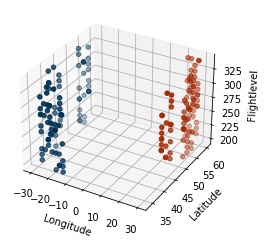

In [5]:
#%matplotlib notebook
flight_dict = flight_df.to_dict()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_s = np.fromiter(flight_dict["start_longitudinal"].values(), dtype=float)
y_s = np.fromiter(flight_dict["start_latitudinal"].values(), dtype=float)
z_s = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)

x_e = np.fromiter(flight_dict["end_longitudinal"].values(), dtype=float)
y_e = np.fromiter(flight_dict["end_latitudinal"].values(), dtype=float)
z_e = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Flightlevel")

ax.scatter(x_s, y_s, z_s,c="#003153")
ax.scatter(x_e, y_e, z_e, c="#A42A04")

#ax.invert_zaxis()

plt.show()

# Load velocity and fuel consumption data

In [6]:
fuel_df = pd.read_csv("../data/bada_data.csv", sep=";")
cruise_df_temp = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,1,2]]
climb_df = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,3,4,5]]
descent_df = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,6,7,8]]

In [7]:
cruise_df = cruise_df_temp.drop(index=[0,1,2,3,4,5,6,7,8]).reset_index() # remove FL below 100
cruise_df.drop(cruise_df[cruise_df.FL<200].index, inplace=True)
cruise_df = cruise_df.reset_index()
cruise_df.drop(columns=["level_0","index"],inplace=True)

In [8]:
fl = cruise_df["FL"].to_numpy()
tas = cruise_df["TAS [kts]"].to_numpy()
fuel = cruise_df["fuel [kg/min]"].to_numpy()

# Load climate data

In [194]:
def xyz_to_tupel(x, y, z):
    if math.isnan(z):
        return (float("nan"),float("nan"),float("nan"))
    else:
        return (  int((x+30)/2), int((y-34)/2), int((z-100)/20))

In [11]:
convert_dict = {
    600: (100, 120, 140), 
    550: (160, float("nan"), float("nan")), 
    500: (180, float("nan"), float("nan")), 
    450: (200, 220, float("nan")), 
    400: (240, float("nan"), float("nan")), 
    350: (260, 280, float("nan")), 
    300: (300, 320, float("nan")),
    250: (340, float("nan"), float("nan")), 
    225: (360, float("nan"), float("nan")), 
    200: (380, 400, float("nan"))} 

In [198]:
ds = xr.open_dataset("../data/aCCF_0623_p_spec.nc")
climate_df_temp = ds.to_dataframe()
climate_df = climate_df_temp.reset_index()
climate_df.drop(columns=["LEVEL11_24_bnds","bnds","SG_NOX","SG_DCONT","SG_H2O","E022"], inplace=True)
climate_df.drop(climate_df[climate_df.LONGITUDE<-30].index, inplace=True)
climate_df.reset_index(inplace=True)

hpa_old = climate_df["LEVEL11_24"].to_numpy()
fl_mapped = []#np.zeros(len(hpa_old))
rem_index = []

for i in range(len(hpa_old)):
    if hpa_old[i] in convert_dict:
        fl_mapped.append( convert_dict[hpa_old[i]])
    else:
        fl_mapped.append(float("nan")  )
        rem_index.append(i)

climate_df["FL"] = fl_mapped
climate_df.drop(rem_index, inplace=True)
climate_df.reset_index(inplace=True)
climate_df.drop(columns=["level_0","index"],inplace=True)

    

temp_x = climate_df["LONGITUDE"].to_numpy()
temp_y = climate_df["LATITUDE"].to_numpy()
temp_z = climate_df["FL"].to_numpy()

tupel_arr = []
for x,y,temp_z_arr in zip(temp_x, temp_y, temp_z):
    temp_tupel = ()
    for z in temp_z_arr:
        temp_tupel = (xyz_to_tupel(x,y,z),) + temp_tupel 
    tupel_arr += [temp_tupel[::-1]]
climate_df["tupel"] = tupel_arr 
climate_df.drop_duplicates(inplace=True)
climate_df.reset_index(inplace=True)
climate_df.drop(columns=["index"],inplace=True)
climate_df

,LONGITUDE,LATITUDE,LEVEL11_24,TIME,MERGED,FL,tupel
0,-30.0,34.0,200,2018-06-23 06:00:00,0.088344,"(380, 400, nan)","((0, 0, 14), (0, 0, 15), (nan, nan, nan))"
1,-30.0,34.0,200,2018-06-23 12:00:00,0.088190,"(380, 400, nan)","((0, 0, 14), (0, 0, 15), (nan, nan, nan))"
2,-30.0,34.0,200,2018-06-23 18:00:00,0.088036,"(380, 400, nan)","((0, 0, 14), (0, 0, 15), (nan, nan, nan))"
3,-30.0,34.0,225,2018-06-23 06:00:00,0.084318,"(360, nan, nan)","((0, 0, 13), (nan, nan, nan), (nan, nan, nan))"
4,-30.0,34.0,225,2018-06-23 12:00:00,0.084189,"(360, nan, nan)","((0, 0, 13), (nan, nan, nan), (nan, nan, nan))"
...,...,...,...,...,...,...,...
13015,30.0,60.0,550,2018-06-23 12:00:00,0.112334,"(160, nan, nan)","((30, 13, 3), (nan, nan, nan), (nan, nan, nan))"
13016,30.0,60.0,550,2018-06-23 18:00:00,0.114098,"(160, nan, nan)","((30, 13, 3), (nan, nan, nan), (nan, nan, nan))"
13017,30.0,60.0,600,2018-06-23 06:00:00,0.116333,"(100, 120, 140)","((30, 13, 0), (30, 13, 1), (30, 13, 2))"
13018,30.0,60.0,600,2018-06-23 12:00:00,0.118673,"(100, 120, 140)","((30, 13, 0), (30, 13, 1), (30, 13, 2))"


# Define functions to relate measured data to parametrized voxels

In [14]:
def x_to_km(deg):
    "return km"
    return deg*85

def y_to_km(deg):
    "return km"
    return deg*111

In [15]:
def find_x(x_hat):
    inx = (np.abs(x_arr - x_hat)).argmin()
    return x_arr[inx]

def find_y(y_hat):
    inx = (np.abs(y_arr - y_hat)).argmin()
    return y_arr[inx]

def find_z(z_hat):
    inx = (np.abs(z_arr - z_hat)).argmin()
    return z_arr[inx]

In [16]:
def find_z_arr(z_hat):
    
    nearest_val = z_hat
    difference = z_hat
    
    for cnt, arr in enumerate(convert_dict.values()):
        for test_fl in arr:
            if np.abs(test_fl - z_hat) < difference:
                nearest_val = arr
                difference = np.abs(test_fl - z_hat)
    
    return nearest_val

In [17]:
def find_fuel(df, FL_val):
    """"returns TAS and fuel consumption in kg/min """
    inx = (np.abs(df["FL"].to_numpy() - FL_val )).argmin()
   
    cl_inx = df.index[inx]
    
    return df.iloc[cl_inx].values[1],float(df.iloc[cl_inx].values[2].replace(",","."))

# find_fuel(cruise_df,250)

In [18]:
#The trajectory for each airplane is defined as a list of points, altitudes, and time stamps
def consumed_fuel(trajectory):
    c_fuel = 0 
    
    c_fuel_dict = {0:[trajectory[0]["x"],trajectory[0]["y"],trajectory[0]["z"],0]}
    for cnt in range(len(trajectory)-1):
        temp_fuel = 0 
        z_0 = trajectory[cnt]["z"] 
        z_1 = trajectory[cnt+1]["z"] 
        
        consumption_rate_0 = find_fuel(cruise_df,z_0)[-1] # in kg/min
        consumption_rate_1 = find_fuel(cruise_df,z_1)[-1] # in kg/min
        
        delta_t = np.abs(trajectory[cnt+1]["t"] - trajectory[cnt]["t"] ).astype(float)
        
        temp_fuel += consumption_rate_0 * delta_t/(2*60) 
        temp_fuel += consumption_rate_1 * delta_t/(2*60) 
        c_fuel_dict[cnt+1] = [trajectory[cnt+1]["x"],trajectory[cnt+1]["y"],z_1,temp_fuel]
        c_fuel += temp_fuel
        
    return c_fuel, c_fuel_dict
# test_traj = [{"x": 25, "y":50, "z":400 , "t":np.datetime64("2018-06-23 06:00:00")  }, {"x": 27, "y":50, "z":400 , "t": np.datetime64("2018-06-23 12:00:00") }]

In [145]:
def find_climate(df, x, y, z, t):
    
    scaled_x = find_x(x)
    scaled_y = find_y(y)
    scaled_z = find_z_arr(z)

    temp_series = df.loc[(df["LONGITUDE"] == scaled_x) & (df["LATITUDE"] == scaled_y) & (df["FL"] == scaled_z), "TIME"].dt.hour

    inx = (np.abs(temp_series.to_numpy() - ( (t-t.astype('datetime64[D]'))/3600).astype(int)   )).argmin()
    r_inx = temp_series.index[inx]
    ret = df.loc[(df["LONGITUDE"] == scaled_x) & (df["LATITUDE"] == scaled_y) & (df["FL"] == scaled_z) & (df["TIME"] == np.datetime64('2018-06-23') + np.timedelta64(temp_series.loc[r_inx],'h') ), "MERGED"]
    
    return ret 

# find_climate(climate_df, x=30, y=56, z=400, t=np.datetime64("2018-06-23 06:00:00"))

# Define navigation functions

In [20]:
def rad_change_direction(v,angle):
    rad = angle*np.pi/180
    return v**2/(np.tan(rad))*0.0000269
rad_change_direction(400,25)
# normalized to km

9.229957785873141

longest way through voxel is diagonal, therefore use that as upper bound 

In [21]:
x_to_km(2), y_to_km(2), np.sqrt(170**2 + 222**2)

(170, 222, 279.6140196771256)

In [22]:
170*222*0.06096/(0.3048*9.26*279)

2.9215727257948396

I.e. max 3 planes in a voxel at a given time 

# Define Cost function and constraints

In [23]:
# todo: overlap at different times 

In [25]:
def constraint_n_planes(trajec_arr):
    flat_traj = []
    for sublist in trajec_arr:
        for item in sublist:
            flat_traj.append(list(item.values()))
    flat_traj = np.array(flat_traj)


    _, index, count = np.unique(np.array(flat_traj[:,0:3], dtype=float),axis=0,  return_index=True,return_counts=True)

    # remove if xyz are only in complete traj once 
    rem_index = []
    for (i,c) in zip(index, count):
        if c == 1:
            rem_index.append(i)

    rem_flat_traj = np.delete(flat_traj, rem_index,axis=0)

    # if time difference shows that they are in voxel at the same time 
    overlap_dict = {}
    overlap_cnt = 0
    for cnt, check_arr in enumerate(rem_flat_traj):
        for test_arr in rem_flat_traj[cnt+1:]:
            if  np.array_equal(check_arr[0:3], test_arr[0:3]): 
                time_diff = np.abs(check_arr[3] - test_arr[3])
                if time_diff < check_arr[4]:
#                     voxel_mult_planes.append(check_arr)
#                     overlap_arr.append([check_arr,test_arr])
                    overlap_cnt += 1
                    x,y,z = check_arr[0:3]     
                    if str(x)+"_"+str(y)+"_"+str(z) in overlap_dict:
                        overlap_dict[str(x)+"_"+str(y)+"_"+str(z)] += [check_arr[3],test_arr[3]]
                    else: 
                        overlap_dict[str(x)+"_"+str(y)+"_"+str(z)] = [check_arr[3],test_arr[3]]
#     voxel_mult_planes = np.array(voxel_mult_planes)

#     _, index, count = np.unique(np.array(voxel_mult_planes[:,0:3], dtype=float),axis=0,  return_index=True,return_counts=True)


#     unvalid_traj_cnt = 0
#     index_arr = []
#     for (i,c) in zip(index, count):
#         if c > 2:
#             print(c)
#             unvalid_traj_cnt += c
#             index_arr.append(i)
    
#     for x,y,z,t,delta in voxel_mult_planes:
#         for inx in index_arr:
#             if x == voxel_mult_planes[inx][0] and y == voxel_mult_planes[inx][1] and z == voxel_mult_planes[inx][2]:
#                 print(x,y,z,t )
# now conflicts at different times get put into same. See if this is problem
#     c = 0 
# for k,v in d.items():
#     if len(v) != 2:
#         c+=1
#         print(len(v))
# c        
    return overlap_cnt, overlap_dict
# c,d = constraint_n_planes(classical_trajectory_arr)

In [79]:
# d

In [27]:
final_x_arr = flight_df.end_longitudinal.to_numpy()
final_y_arr = flight_df.end_latitudinal.to_numpy()
def constraint_final_xy(trajec_arr):
    x_error = 0
    y_error = 0 
    for cnt, traj in enumerate(trajec_arr):
        if traj[-1]["x"] != final_x_arr[cnt]:
            x_error += 1
        elif traj[-1]["y"] != final_y_arr[cnt]:
            y_error += 1
    return x_error + y_error
# constraint_final_xy(classical_trajectory_arr)

In [28]:
def constraint_path(trajec_arr):
    path_error = 0
    
    for cnt, traj in enumerate(trajec_arr):
        for step in range(len(traj)-1):
            delta_x = np.abs(traj[step+1]["x"] - traj[step]["x"])
            delta_y = np.abs(traj[step+1]["y"] - traj[step]["y"])
            delta_z = np.abs(traj[step+1]["z"] - traj[step]["z"])
            
            if   delta_x == 2 and delta_y == 0 and delta_z == 0:
                1
            elif delta_x == 0 and delta_y == 2 and delta_z == 0:
                1
            elif delta_x == 2 and delta_y == 2 and delta_z == 0:
                1
            elif delta_x == 2 and delta_y == 0 and delta_z == 20:
                1
            elif delta_x == 0 and delta_y == 2 and delta_z == 20:
                1
            elif delta_x == 2 and delta_y == 2 and delta_z == 20:
                1
            else:
                path_error += 1
                
    return path_error

# constraint_path(classical_trajectory_arr)

In [29]:

#The trajectory for each airplane is defined as a list of points, altitudes, and time stamps
def consumed_fuel(trajectory):
    c_fuel = 0 
    
    c_fuel_dict = {0:[trajectory[0]["x"],trajectory[0]["y"],trajectory[0]["z"],0]}
    for cnt in range(len(trajectory)-1):
        temp_fuel = 0 
        z_0 = trajectory[cnt]["z"] 
        z_1 = trajectory[cnt+1]["z"] 
        
        consumption_rate_0 = find_fuel(cruise_df,z_0)[-1] # in kg/min
        consumption_rate_1 = find_fuel(cruise_df,z_1)[-1] # in kg/min
        
        delta_t = np.abs(trajectory[cnt+1]["t"] - trajectory[cnt]["t"] ).astype(float)
        
        temp_fuel += consumption_rate_0 * delta_t/(2*60) 
        temp_fuel += consumption_rate_1 * delta_t/(2*60) 
        c_fuel_dict[cnt+1] = [trajectory[cnt+1]["x"],trajectory[cnt+1]["y"],z_1,temp_fuel]
        c_fuel += temp_fuel
        
    return c_fuel, c_fuel_dict
# test_traj = [{"x": 25, "y":50, "z":400 , "t":np.datetime64("2018-06-23 06:00:00")  }, {"x": 27, "y":50, "z":400 , "t": np.datetime64("2018-06-23 12:00:00") }]

In [30]:
# constraining parameters
con_vertical = 0.3048 # km
con_horizont = 9.26 # km
con_inclination = 25 # deg only above this
p = 100 

In [31]:
def C(trajectory):
    
    c_fuel = consumed_fuel(trajectory)[0] # kg 
    
    #delta_CO2 = 6.94 * 10**(-12) # K/kg fuel
    
    effect_sum = np.sum([find_climate(climate_df, x=point["x"], y=point["y"], z=point["z"], t=point["t"]) for point in trajectory])
    
    delta_c = effect_sum*10**(-12) # K/kg fuel
    
    return (delta_c)*c_fuel

In [204]:
# remove vertical 
test = nx.grid_graph(dim=(2,2,2))
test.edges()
e = ((0, 0, 0), (0, 0, 1))
test.remove_edge(*e)

# add diagonal
test.add_edge(*e)
test.edges()

EdgeView([((0, 0, 0), (1, 0, 0)), ((0, 0, 0), (0, 1, 0)), ((0, 0, 0), (0, 0, 1)), ((0, 0, 1), (1, 0, 1)), ((0, 0, 1), (0, 1, 1)), ((0, 1, 0), (1, 1, 0)), ((0, 1, 0), (0, 1, 1)), ((0, 1, 1), (1, 1, 1)), ((1, 0, 0), (1, 1, 0)), ((1, 0, 0), (1, 0, 1)), ((1, 0, 1), (1, 1, 1)), ((1, 1, 0), (1, 1, 1))])

# Optimize single flight

In [34]:
G = nx.grid_graph(dim=(z_arr.shape[0],y_arr.shape[0],x_arr.shape[0]))
print(x_arr.shape[0],y_arr.shape[0],z_arr.shape[0])
len(G.edges()), len(G.nodes())

31 14 16


(19678, 6944)

In [54]:
def tupel_to_tupel_arr(tupel):
    x,y,z = tupel
    fl = 20*z + 100
    match_z_arr = find_z_arr(fl)

    found = False 
    for cnt, tupel_set in enumerate(climate_df.loc[climate_df["FL"] == match_z_arr,"tupel"].to_numpy()):
        for cnt_2, test_tuple in enumerate(tupel_set):
            if tupel == test_tuple:
                
                found = True 
                break
        if found:
            break
    
    return tupel_set, cnt_2
tupel_to_tupel_arr((29,5,11))

(((29, 5, 10), (29, 5, 11), (nan, nan, nan)), 1)

In [41]:
def z_to_km(fl):
    return 144*fl/20

In [45]:
def c_weight(df, tupel_0, tupel_1):
    
    tupel_arr_0, t0_pos = tupel_to_tupel_arr(tupel_0)
    tupel_arr_1, t1_pos = tupel_to_tupel_arr(tupel_1)
    
    m_0 = df.loc[df["tupel"] == tupel_arr_0,"MERGED"].mean() # take mean of merged for 3 times 
    m_1 = df.loc[df["tupel"] == tupel_arr_1,"MERGED"].mean()
    
    
    fl_0 = df.loc[df["tupel"] == tupel_arr_0,"FL"].to_numpy()[0][t0_pos] 
    fl_1 = df.loc[df["tupel"] == tupel_arr_1,"FL"].to_numpy()[0][t1_pos]
    
    v_0, f_0 = find_fuel(fuel_df,fl_0)
    v_1, f_1 = find_fuel(fuel_df,fl_1)
    
    if tupel_0[0] - tupel_1[0] != 0:
        dist = x_to_km(2)        
    elif tupel_0[1] - tupel_1[1] != 0:
        dist = y_to_km(2)        
    elif tupel_0[2] - tupel_1[2] != 0:
        dist = z_to_km(20)  # improve, also time needs to be adjusted for this one 
    else:
        print("Invalid tupel")
        dist = 10000
    
    
    t_0 = dist/(2*v_0*1.85*60) 
    t_1 = dist/(2*v_1*1.85*60)    
    c_impact = t_0*f_0* + t_1*f_1  # kg , scaled by *10**(12)
    
    return c_impact
c_weight(climate_df, (0,0,1), (0,0,2))

0.007347215889130431

for edge weight consider cost to go from voxel to voxel 
for this consider voxels (0,0,0) and (0,0,1) 
take av merged at both and fuel cons of first 

In [46]:
# edge weights have to be mult by fuel cons already 
cnt = 0 
for e in G.edges():
    try:
        G[e[0]][e[1]]["w"] = c_weight(climate_df, e[0], e[1])
    except:
        cnt += 1 

In [48]:
# for index, t, z, x_s, y_s, x_e, y_e in flight_df.to_numpy():
index, t, z, x_s, y_s, x_e, y_e = flight_df.to_numpy()[0]

x_s, y_s, z, x_e, y_e

(-30, 56, 250, 24, 60)

In [58]:
# pick either 128 256 512

rand_paths = [itertools.islice(nx.shortest_simple_paths(G, source= xyz_to_tupel( x_s, y_s, z), target=xyz_to_tupel( x_e, y_e, z_e), weight="w"), 2) for z_e in z_arr ]

tupel_path_arr = []
for path_z in list(rand_paths):
    
    for path in path_z:
        tupel_path_arr.append(path)
        #         print(nx.path_weight(G,path,"w"))
    

In [73]:
# for path in tupel_path_arr:
def tupel_path_to_trajec(tupel_path):
    shifted_path = []
    for tupel in tupel_path:
        tupel_arr, t_inx = tupel_to_tupel_arr(tupel)
        x = climate_df.loc[climate_df["tupel"] == tupel_arr,"LONGITUDE"].to_numpy()[0]
        y = climate_df.loc[climate_df["tupel"] == tupel_arr,"LATITUDE"].to_numpy()[0]
        z = climate_df.loc[climate_df["tupel"] == tupel_arr,"FL"].to_numpy()[0][t_inx]

        shifted_path.append({"x":x,
                             "y":y,
                             "z":z
                            })


    shifted_path[0]["t"] =  np.datetime64('2018-06-23 '+ t) 
    shifted_path[0]["delta_t"] = np.timedelta64(0,'s')

    for i in range(len(shifted_path)-1):
        point_x = x_to_km(np.abs(shifted_path[i+1]["x"] - shifted_path[i]["x"]))
        point_y = y_to_km(np.abs(shifted_path[i+1]["y"] - shifted_path[i]["y"]))
        point_z = z_to_km(np.abs(shifted_path[i+1]["z"] - shifted_path[i]["z"]))

    #     print(point_x,point_y,point_z, shifted_path[i+1]["z"])
        point_dist = np.sqrt(point_x**2 + point_y**2 + point_z**2)

        point_t = int(3600 * point_dist/ (find_fuel(cruise_df,z)[0] * 1.852))

        shifted_path[i+1]["t"] = shifted_path[i]["t"] + np.timedelta64(point_t,'s')
        shifted_path[i+1]["delta_t"] = np.timedelta64(point_t,'s')
    
    return shifted_path

In [146]:
test_trajec = [tupel_path_to_trajec(tupel_path) for tupel_path in tupel_path_arr]

In [165]:
def convertTuple(tup):
    st = ''.join(map(str, tup))
    return st

def grover_search(N, index, n_iter):
    aer_simulator = Aer.get_backend('aer_simulator')
    lst = list(itertools.product([0, 1], repeat=N))
    sv_labels = [convertTuple(l) for l in lst]
    sv_label = sv_labels[index]
    
    oracle = Statevector.from_label(sv_label)
    problem = AmplificationProblem(oracle, is_good_state=[sv_label])

    grover = Grover(quantum_instance=aer_simulator, iterations=n_iter)
    result = grover.amplify(problem)
   
    
    res = result.top_measurement if result.oracle_evaluation else False
    found_inx = np.where(np.array(sv_label) == res)[0][0]
    
    return str(res), found_inx
#grover_search(N=5, index=10, n_iter=10)

In [156]:
# map comp basis state to trajec
N = 5
lst = list(itertools.product([0, 1], repeat=N))
basis_state_to_trajec = {}
for cnt, b_state in enumerate(lst):
    basis_state_to_trajec[convertTuple(b_state)] = test_trajec[cnt]
state_arr = np.array([convertTuple(l) for l in lst])

In [843]:
# oracle = Statevector.from_label('00000')
# problem = AmplificationProblem(oracle, is_good_state=['00000'])

# grover = Grover(quantum_instance=aer_simulator)
# result = grover.amplify(problem)
# print('Result type:', type(result))
# print()
# print('Success!' if result.oracle_evaluation else 'Failure!')
# print('Top measurement:', result.top_measurement)

In [160]:
def cost(x):
    return C(basis_state_to_trajec[x])
cost("00100")

1.6893100297189744e-07

In [185]:
def findMinCostQuantum(state_arr):
    """Input : a list of size N containing all the possible states of the system.
    Output: (the index of an admissible state which has the minimum cost, the associated minimum
    cost)."""
    y = state_arr[np.random.choice(np.arange(state_arr.size))]
    m = 1
    G = 0
    l = 1.34#8/7
    l = 8/7
    
    N = len(state_arr)
    n_qubits = np.log(N)/np.log(2)
    
    while G < 22.5*np.sqrt(N) + 1.4*np.log(N)**2: 
        
        if m == 1:
            r = 0
        else:
            r = np.random.randint(0, math.ceil(m-1))
        
        n_iter = int(np.pi/4 * np.sqrt(N))
        #Perform Grover’s search with r rotation to find a state 
        x, x_inx = grover_search(N = 5, index = r, n_iter = n_iter)
        
        G = G + r
        
        if cost(x) < cost(y):
            y = x
            m = 1
        else:
            x = y
            m = l*m
        
    return (x, cost(x))

In [186]:
findMinCostQuantum(state_arr)

('01011', 1.2439259139465453e-07)

In [192]:
plot_y

[56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 58.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0]

In [187]:
plot_x = [ temp["x"]  for temp in  basis_state_to_trajec['01011'] ]
plot_y = [ temp["y"]  for temp in  basis_state_to_trajec['01011'] ]
plot_z = [ temp["z"]  for temp in  basis_state_to_trajec['01011'] ]

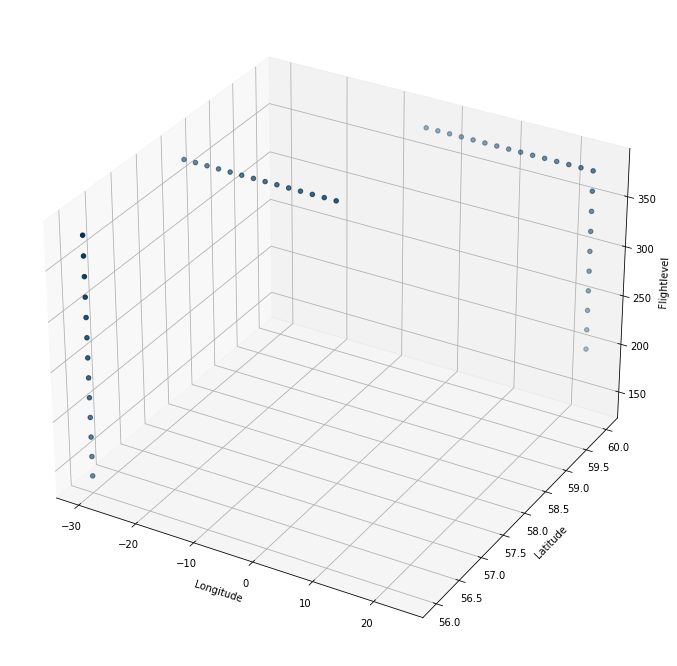

In [189]:
#%matplotlib notebook
flight_dict = flight_df.to_dict()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')




ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Flightlevel")

ax.scatter(plot_x, plot_y, plot_z,c="#003153")
# ax.scatter(x_e, y_e, z_e, c="#A42A04")

#ax.invert_zaxis()

plt.show()

# Optimize flights classicaly

In [126]:
classical_trajectory_arr = []
for index, t, z, x_s, y_s, x_e, y_e in flight_df.to_numpy():
    
    x_tr = np.linspace(x_s,x_e,100)
    y_tr = np.linspace(y_s,y_e,100)
    
    
    temp_trajec = []
    for i in range(99):        
        temp_trajec.append({"x": x_tr[i+1], "y":y_tr[i+1] })
    
    
    traj_voxel = []

    for c_1, i in enumerate(x_arr):
        for c_2, j in enumerate(y_arr):
            for c_3, l in enumerate(temp_trajec):
                if i == x_arr[(np.abs(x_arr - temp_trajec[c_3]["x"]  )).argmin()] and j == y_arr[(np.abs(y_arr - temp_trajec[c_3]["y"]  )).argmin()]:
                    traj_voxel += [[x_arr[c_1],y_arr[c_2]]]
                    
    traj_voxel = np.unique(traj_voxel,axis=0)
    
   
    traj = [{"x": x_s, "y":y_s, "z":z , "t": np.datetime64('2018-06-23 '+ t) , "delta_t":np.timedelta64(0,'s')  }]
    for i in range(len(traj_voxel)-1):
        point_x = x_to_km(traj_voxel[i+1][0] - traj_voxel[i][0])
        point_y = y_to_km(traj_voxel[i+1][1] - traj_voxel[i][1])
        point_dist = np.sqrt(point_x**2 + point_y**2)
        
        point_t = int(3600 * point_dist/ (find_fuel(cruise_df,z)[0] * 1.852))
        
        traj.append({"x": traj_voxel[i+1][0], "y":traj_voxel[i+1][1], "z":z , "t":traj[i]["t"] + np.timedelta64(point_t,'s'), "delta_t":np.timedelta64(point_t,'s')  })
    classical_trajectory_arr.append(traj)
######
test_classical_traj = classical_trajectory_arr[2]

box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        
        box_2d[c_1][c_2] = 1
        
        for c_3, l in enumerate(test_classical_traj):

#             if i == x_arr[(np.abs(x_arr - tr_1[c_3]["x"]  )).argmin()] and j == y_arr[(np.abs(y_arr - tr_1[c_3]["y"]  )).argmin()]:
#                 box_2d[c_1][c_2] = 0.5
#                 traj_voxel += [[x_arr[c_1],y_arr[c_2]]]
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = 0.5
                
                            
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0.5)
ax.set_ylabel("Longitude (W-E)")
ax.set_xlabel("Latitude (N-S)")
plt.show()
######
classical_delta_T = np.sum([C(tr) for tr in classical_trajectory_arr])

# Circuit plot

In [193]:
# x_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "LONGITUDE"].to_numpy()
# y_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "LATITUDE"].to_numpy()
# merged_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "MERGED"].to_numpy()

In [844]:
# fig, ax = plt.subplots(dpi=150)


# ax.plot(fl, tas, label= "TAS [kts]",color="#003153", mec="black", marker="o", ms=8)#[[0,0.1922,0.3255]]


# ax2 = ax.twinx()


# ax2.plot(fl, fuel, label="Fuel [kg/min]",color="#A42A04", mec='black', marker="o", ms=8)    


# ax2.invert_yaxis()

# ax.set_xlabel("Flight Level", fontsize=12)
# ax2.set_ylabel("Fuel Consumption rate",fontsize=12)
# ax.set_ylabel("True Air Speed",fontsize=12)

# fig.legend(bbox_to_anchor=(0.65, 0.88), loc=2)

In [845]:
# import matplotlib.ticker as ticker
# box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

# for c_1, i in enumerate(x_arr):
#     for c_2, j in enumerate(y_arr):
        
#         merged_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 400) & (climate_df["TIME"] == "2018-06-23 06:00:00") & (climate_df["LONGITUDE"] == i) & (climate_df["LATITUDE"] == j), "MERGED"].to_numpy()
        
#         box_2d[c_1][c_2] = merged_plot[0]
                
# fig, ax = plt.subplots(dpi=250) 
# #sns.set(font_scale = 0.5)
# ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0)
# ax.set_ylabel("Longitude")
# ax.set_xlabel("Latitude")

    
# ax.xaxis.label.set_fontsize(12)
# ax.yaxis.label.set_fontsize(12)

# ax.xaxis.set_tick_params(labelsize=12)
# ax.yaxis.set_tick_params(labelsize=12)


# ax.set_yticks(ax.get_yticks()[::2])
# ax.legend
# plt.show()

In [819]:
oracle = QuantumCircuit(5)
oracle.initialize("00000",oracle.qubits)
good_state = Statevector.from_label('00000')
oracle.draw()


grover_op = GroverOperator(oracle)
grover_op.decompose().draw() #output='mpl'

global phase: π
         ┌────────────────────────┐┌───┐┌───┐          ┌───┐┌───┐     
state_0: ┤0                       ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤       │  ├───┤├───┤     
state_1: ┤1                       ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤       │  ├───┤├───┤     
state_2: ┤2 Initialize(0,0,0,0,0) ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤       │  ├───┤├───┤     
state_3: ┤3                       ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
state_4: ┤4                       ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
         └────────────────────────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [567]:
# problem.grover_operator.oracle.decompose().draw()